In [14]:
#In this analyis we're using two lists of targets generated by querying uniprot for sequences with specific
#GO terms related to biological processes but the steps performed are applicable to any starting set
#of putative interactors which may show correlation in evolutionary and expression signals
#due to their involvment in similar biological processes.

import pandas as pd
import numpy as np
#lets load our queries
queries = pd.read_table( './torwbgee.tab')
additionalqueries = ['FKBP15' , 'Q9ULK8' ]
queries['pathway'] = 'MTOR'

#this set of genes unrelated to MTOR will serve as an outgroup to our MTOR related genes
#their evolutionary and expression profiles should not correlate well with MTOR
#let's select a few genes from the wnt pathway 
bmpqueries = pd.read_table( './musclecontraction.tab')

bmpqueries['pathway']='MuscleContraction'
queries = pd.concat([queries,bmpqueries])
print(queries)

names= { q.Entry:q['Entry name'].split('_')[0]+ ' '+q.pathway for index,q in queries[['Entry','Entry name','pathway']].iterrows() if q['Entry name'] is not np.nan }
print(names)


         Entry        Entry name      Status  \
0       Q13541       4EBP1_HUMAN    reviewed   
1       Q13542       4EBP2_HUMAN    reviewed   
2       Q9BVC4        LST8_HUMAN    reviewed   
3       Q96A49       SYAP1_HUMAN    reviewed   
4       Q9BPZ7        SIN1_HUMAN    reviewed   
5       P58005       SESN3_HUMAN    reviewed   
6       P62753         RS6_HUMAN    reviewed   
7       Q6R327       RICTR_HUMAN    reviewed   
8       Q8N122       RPTOR_HUMAN    reviewed   
9       Q6MZQ0       PRR5L_HUMAN    reviewed   
10      Q9BXM7       PINK1_HUMAN    reviewed   
11      Q8TAI7       REBL1_HUMAN    reviewed   
12      Q12980       NPRL3_HUMAN    reviewed   
13      Q6PKG0       LARP1_HUMAN    reviewed   
14      Q6P9B6       MEAK7_HUMAN    reviewed   
15      Q8TF40       FNIP1_HUMAN    reviewed   
16      P42345        MTOR_HUMAN    reviewed   
17      P23443       KS6B1_HUMAN    reviewed   
18      Q9BXL7       CAR11_HUMAN    reviewed   
19      Q9UBS0       KS6B2_HUMAN    revi

/home/cactuskid/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  if __name__ == '__main__':
/home/cactuskid/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  app.launch_new_instance()


In [7]:
import seaborn as sns
from matplotlib import pyplot as plt
metrics = [ 'euclidean', 'hamming', 'jaccard' ]
methods = [ 'average' , 'weighted' , 'centroid']


In [8]:
from omadb import Client
c = Client()
omadata = {}
#retrieve oma entries

for q in list(queries['Entry']) + additionalqueries:    
    try:
        omadata[q] = c.entries.__getitem__(q) 
    except:
        print('err ' +q)


err I3L2E7
err D6R9S6
err I3L2I3
err Q6DKI0
err B7Z3S8
err Q8N6M7
err P20929
err FKBP15
err Q9ULK8


In [9]:

orthologs = {}
#get all orthologoues of entries
entry2hogs={}
for q in omadata:
    orthologs[q] = c.entries.orthologs(omadata[q]['omaid']) 


In [15]:
#create input profiles w just orthology data
#use just species codes to generate columns
profiles = {}
for q in orthologs:
    profiles[q] = {}
    profiles[q]['name'] = names[q]
    for o in orthologs[q]:
        s = o['omaid'][0:5]
        if s not in profiles[q]:
            profiles[q][s] = 1
        else:
            profiles[q][s]+=1

columns = set([ s  for q in profiles for s in profiles[q] ])
for q in profiles:
    profiles[q].update( { s : 0 for s in columns if s not in profiles[q] } )

orthosdf = pd.DataFrame.from_dict( profiles , orient = 'index')
orthosdf.index = orthosdf.index + ' : '+orthosdf.name
orthosdf = orthosdf.drop('name', axis = 1)
print(orthosdf)

print(orthosdf.columns)

                                  WALSE  SPIPN  PROCA  LOXAF  ECHTE  RABIT  \
A0A024QZM3 : A0A024QZM3 MTOR          0      0      1      0      1      1   
A0A0A0MR05 : A0A0A0MR05 MTOR          0      0      0      0      0      0   
B4DJ80 : B4DJ80 MTOR                  0      0      1      1      0      1   
B4E2R3 : B4E2R3 MTOR                  0      0      0      0      0      0   
H3BM50 : H3BM50 MTOR                  0      0      0      0      0      0   
H3BN58 : H3BN58 MTOR                  0      0      0      0      0      0   
H3BPT1 : H3BPT1 MTOR                  0      0      0      0      0      0   
H3BPU5 : H3BPU5 MTOR                  0      0      0      0      0      0   
H3BQ74 : H3BQ74 MTOR                  0      0      0      0      0      0   
H3BR25 : H3BR25 MTOR                  0      0      0      0      0      0   
H3BR38 : H3BR38 MTOR                  0      0      0      0      0      0   
H3BSZ4 : H3BSZ4 MTOR                  0      0      0      0    

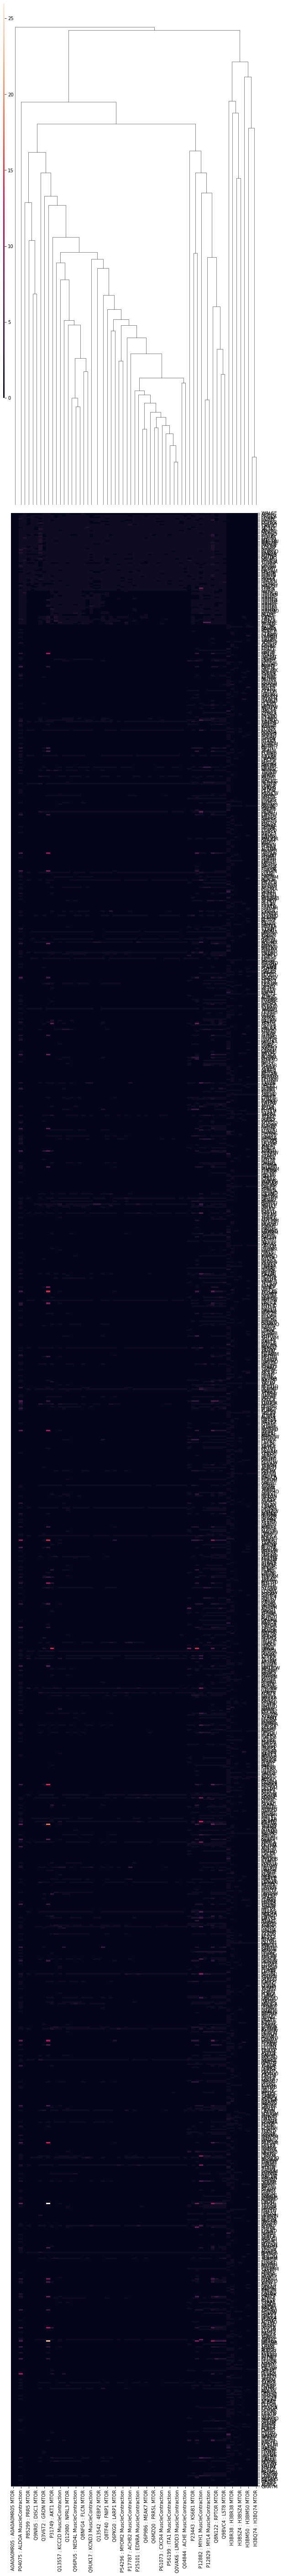

In [16]:

#lets visualize the clustered profile matrix

sns.clustermap( orthosdf.T , metric= metrics[2] , method=methods[1] , col_cluster=True, row_cluster= False, yticklabels = orthosdf.columns , figsize = (10, 100))


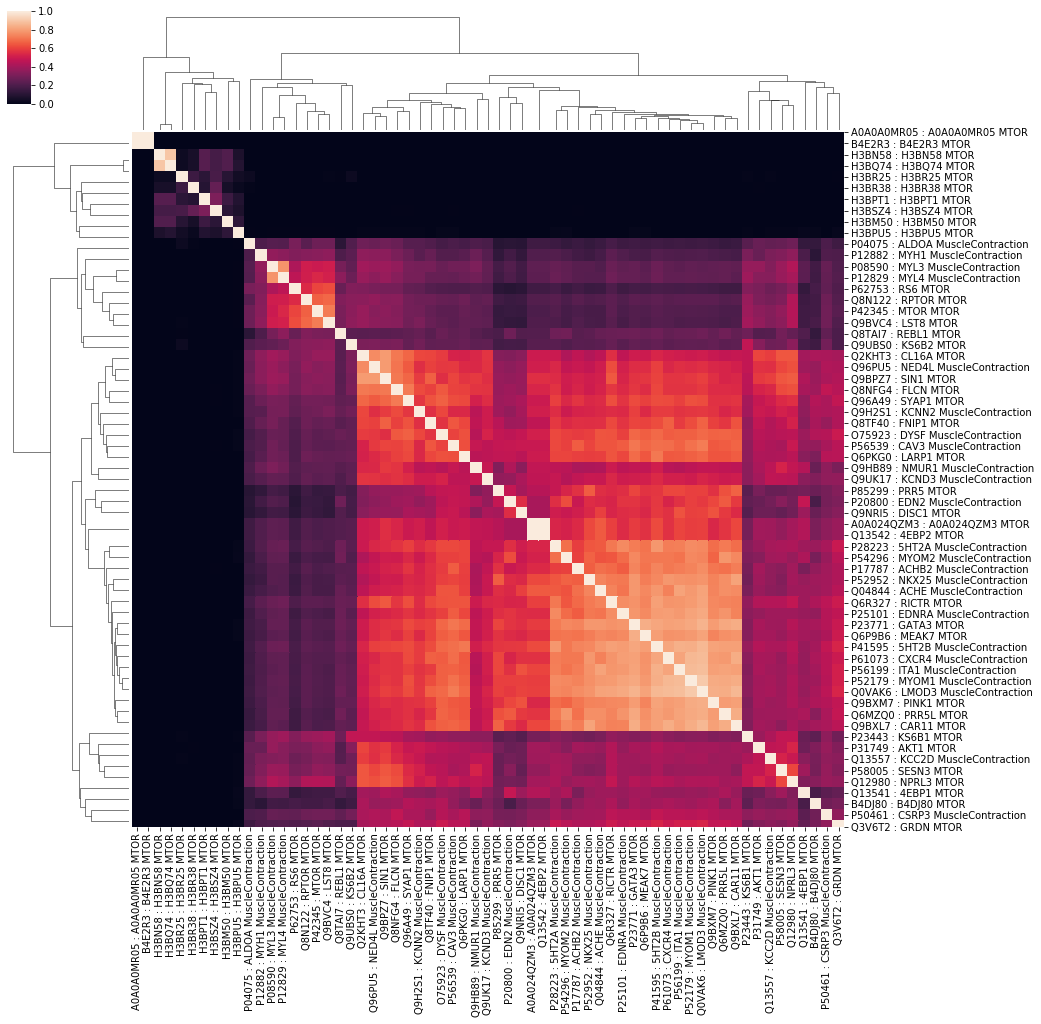

In [17]:
from scipy.spatial.distance import cdist

#and the clustered profile distance kernel
distmat = cdist(orthosdf.to_numpy(), orthosdf.to_numpy() , metric = metrics[2])
sns.clustermap( 1-distmat , metric= metrics[0] , method=methods[1] , col_cluster=True, row_cluster= True, yticklabels = orthosdf.index , xticklabels = orthosdf.index , figsize = (15, 15))



In [18]:
#now with pyham over the all taxonomic levels with evolutionary events
#extra spicy
#load HAM data

import pyham 
database_to_query = 'oma'
Hams = {}
for q in omadata:    
    try:
        Hams[q] = pyham.Ham(query_database=omadata[q]['omaid'], use_data_from=database_to_query) 
    except:
        print('err ' + q)

err Q9BVC4
err P58005
err P62753
err Q8N122
err Q8TAI7
err Q12980
err P42345
err P23443
err Q9UBS0
err P31749
err H3BR25
err H3BN58
err H3BPT1
err H3BM50
err A0A0A0MR05
err H3BSZ4
err H3BR38
err H3BQ74
err B4E2R3
err P12882
err P08590
err P12829
err P04075


In [37]:
#we can look at the evolutionary events that happened to generate the extant distribution of sequences
#for any of the families we were able to retrieve.

#lets look at RPTOR 
#with uniprot identifier I3L2I3
hogs =  Hams['P17787'].get_dict_top_level_hogs() 
prof = Hams['P17787'].create_tree_profile(outfile="jambon.html")


#we can output an html file with an interactive visualization of the
#HOG's enhanced phylogeny

from IPython.core.display import display, HTML
with open( 'jambon.html') as hamin:
    display(HTML(hamin.read()))

In [38]:
#lets look at all the taxonomic levels of our input matrix
taxaIndex = set([ taxon.name for H in Hams for taxon in Hams[H].taxonomy.tree.traverse() ]) 
species = set( [ taxon.name for H in Hams for taxon in Hams[H].taxonomy.tree.get_leaves()])
print('taxa:'+str(len(taxaIndex)))
print('species:'+str(len(species)))


taxa:4606
species:2288


In [51]:
profiles = {}
import numpy as np
#we can construct a matrix representing the evolutionary events for each HOG much like 
#we did using the orthologues in the first step
for q in Hams:
    hogs = Hams[q].get_list_top_level_hogs()
    for hog in hogs:    
        profiles[hog.hog_id] = {}
        tp = Hams[q].create_tree_profile(hog = hog).treemap

        losses = { n.name+'_loss': n.lost  for n in tp.traverse() if n.lost  }
        losses.update( { t+'_loss': 0 for t in taxaIndex if t+'_loss' not in losses} )
        
        profiles[hog.hog_id].update(losses)
        
        dupl = { n.name+'_dupl': n.dupl for n in tp.traverse() if n.dupl   }
        dupl.update( {t+'_dupl': 0 for t in taxaIndex if t+'_dupl' not in dupl} )
        
        profiles[hog.hog_id].update(dupl)
        
        copies = { n.name+'_copies': n.nbr_genes for n in tp.traverse() if n.nbr_genes > 0  }
        nocopies = {t+'_copies': 0 for t in taxaIndex if t+'_copies' not in copies}
        copies.update( nocopies )
        
        profiles[hog.hog_id].update(copies)
        profiles[hog.hog_id]['name']=  names[q]
        


profile_df = pd.DataFrame.from_dict( profiles , orient = 'index')
profile_df.index = profile_df.index +' : ' + profile_df.name
profile_df = profile_df.drop('name' , axis = 1)
print(profile_df)

                                       Amphimedon queenslandica_loss  \
HOG:0409734 : EDN2 MuscleContraction                               0   
HOG:0410267 : DISC1 MTOR                                           0   
HOG:0417945 : MYOM2 MuscleContraction                              0   
HOG:0419343 : MEAK7 MTOR                                           0   
HOG:0419395 : PRR5 MTOR                                            0   
HOG:0419490 : ITA1 MuscleContraction                               0   
HOG:0420192 : ACHE MuscleContraction                               0   
HOG:0421823 : KCNN2 MuscleContraction                              0   
HOG:0422275 : NKX25 MuscleContraction                              0   
HOG:0424065 : PINK1 MTOR                                           0   
HOG:0424704 : PRR5L MTOR                                           0   
HOG:0425937 : MYOM1 MuscleContraction                              0   
HOG:0427754 : CXCR4 MuscleContraction                           

In [52]:
selected_taxa = species
#get the species

events = [ '_copies'  , '_dupl' , '_loss']
cols = [ t+e for e in events for t in taxaIndex ]

#slice the df to get matrices
sub_df = profile_df.loc[:,cols]
sub_df = sub_df.loc[:, (sub_df != 0).any(axis=0)]
print(sub_df)


                                       Vibrio_copies  Culicomorpha_copies  \
HOG:0409734 : EDN2 MuscleContraction               0                    0   
HOG:0410267 : DISC1 MTOR                           0                    0   
HOG:0417945 : MYOM2 MuscleContraction              0                    0   
HOG:0419343 : MEAK7 MTOR                           0                    0   
HOG:0419395 : PRR5 MTOR                            0                    0   
HOG:0419490 : ITA1 MuscleContraction               0                    0   
HOG:0420192 : ACHE MuscleContraction               0                    0   
HOG:0421823 : KCNN2 MuscleContraction              0                    0   
HOG:0422275 : NKX25 MuscleContraction              0                    0   
HOG:0424065 : PINK1 MTOR                           0                    0   
HOG:0424704 : PRR5L MTOR                           0                    0   
HOG:0425937 : MYOM1 MuscleContraction              0                    0   

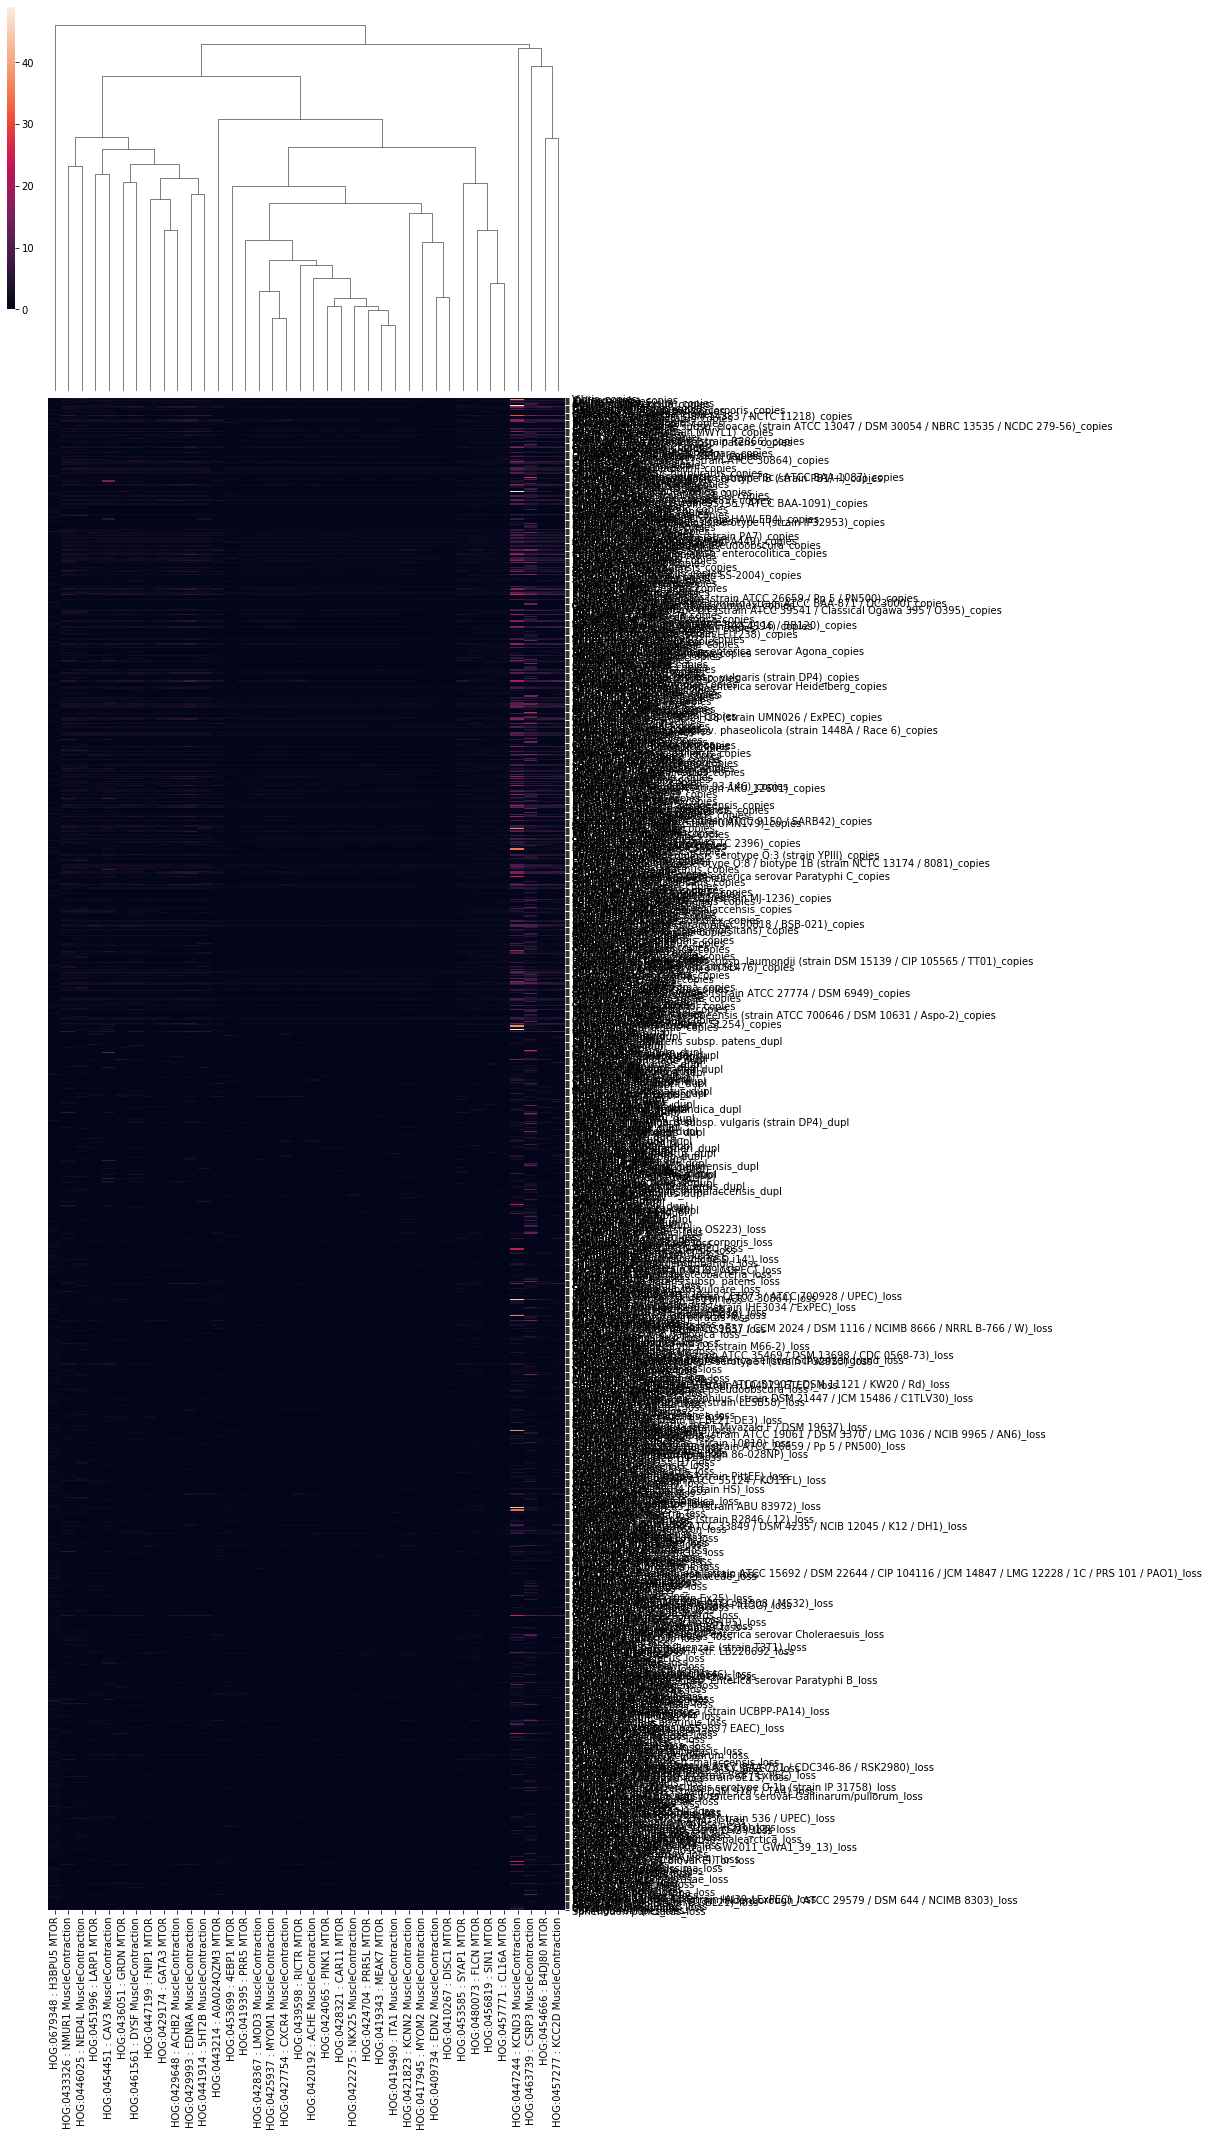

In [53]:
sns.clustermap( sub_df.T , metric= metrics[2] , method=methods[1] , col_cluster=True, row_cluster= False, yticklabels = sub_df.columns , figsize = (10, 35))

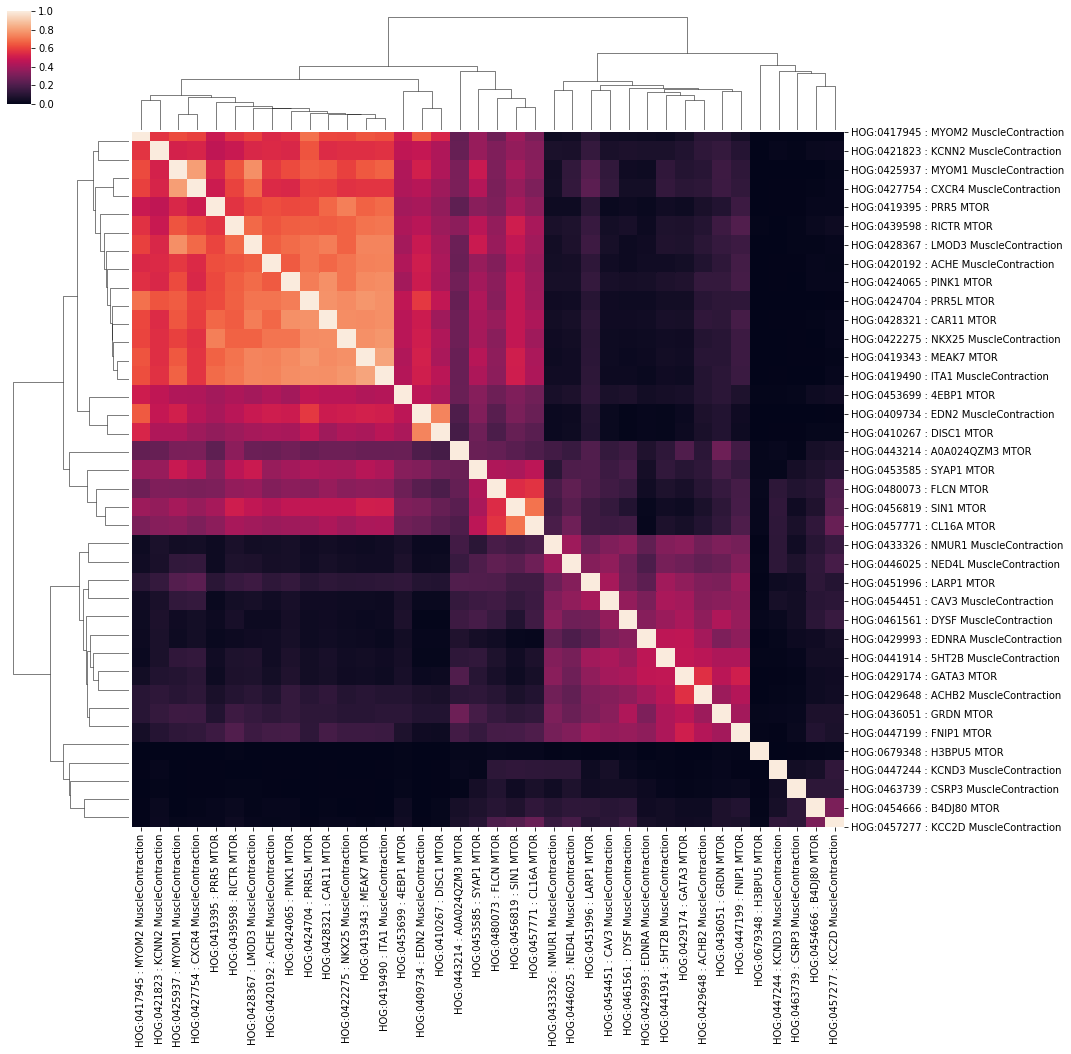

In [79]:
distmat = cdist(sub_df.to_numpy(), sub_df.to_numpy() , metric = metrics[2])
sns.clustermap(1- distmat , metric= metrics[0] , method=methods[0] , col_cluster=True, row_cluster= True, yticklabels = sub_df.index , xticklabels = sub_df.index , figsize = (15, 15))

In [59]:
#let's use independant analysis to comfirm 
#fetching expression data from bgee
#If genes are coexpressed across different tissues in similar patterns 
#they are most likely interacting
#This is more particular to each organism and unrelated to their evolutionary history
#we can get the human ensemble gene IDs from our starting uniprot dataset
qlist = { q.Entry:q['Cross-reference (Bgee)'].replace(';','') for index,q in queries[['Entry','Cross-reference (Bgee)']].iterrows() if q['Cross-reference (Bgee)'] is not np.nan }

qlists = {'HUMAN': qlist }




{'Q13541': 'ENSG00000187840', 'Q13542': 'ENSG00000148730', 'Q9BVC4': 'ENSG00000167965', 'Q96A49': 'ENSG00000169895', 'Q9BPZ7': 'ENSG00000119487', 'P58005': 'ENSG00000149212', 'P62753': 'ENSG00000137154', 'Q6R327': 'ENSG00000164327', 'Q8N122': 'ENSG00000141564', 'Q6MZQ0': 'ENSG00000135362', 'Q9BXM7': 'ENSG00000158828', 'Q8TAI7': 'ENSG00000167550', 'Q12980': 'ENSG00000103148', 'Q6PKG0': 'ENSG00000155506', 'Q6P9B6': 'ENSG00000140950', 'Q8TF40': 'ENSG00000217128', 'P42345': 'ENSG00000198793', 'P23443': 'ENSG00000108443', 'Q9BXL7': 'ENSG00000198286', 'Q9UBS0': 'ENSG00000175634', 'Q2KHT3': 'ENSG00000038532', 'P23771': 'ENSG00000107485', 'P31749': 'ENSG00000142208', 'Q8NFG4': 'ENSG00000154803', 'Q9NRI5': 'ENSG00000162946', 'Q3V6T2': 'ENSG00000115355', 'P85299': 'ENSG00000186654', 'A0A024QZM3': 'ENSG00000148730', 'H3BR25': 'ENSG00000167965', 'H3BN58': 'ENSG00000167965', 'H3BPT1': 'ENSG00000167965', 'H3BM50': 'ENSG00000167965', 'A0A0A0MR05': 'ENSG00000167965', 'H3BSZ4': 'ENSG00000167965', 'H3BP

In [73]:
# now using some cross references to other organisms
xrefs = {}
#we're going to grab the ensemble IDs for the TOR pathway orthologues from a few species
#These are also present in the Bgee dataset
#Bgee species are listed here https://bgee.org
#species information for OMA is available at https://omabrowser.org/All/oma-species.txt

#Ive selected some interesting species...
#let's grab the xrefs for orthologues in these species
species = [ 'DROME','CAEEL' , 'DANRE' , 'MOUSE']

allnames = {}

for q in orthologs:
    for o in orthologs[q]:
        for spec in species:
            if spec not in xrefs:
                xrefs[spec] = {}
            if  o['omaid'][0:5] == spec:
                xrefs[spec][o['omaid'] ] = c.entries.xrefs(o['omaid'])
                if 'UniProtKB/TrEMBL' in xrefs[spec][o['omaid'] ]:
                    names[ xrefs[spec][o['omaid']]['UniProtKB/TrEMBL'][0]] = names[q]
allnames.update(names)


{'Q13541': '4EBP1 MTOR', 'Q13542': '4EBP2 MTOR', 'Q9BVC4': 'LST8 MTOR', 'Q96A49': 'SYAP1 MTOR', 'Q9BPZ7': 'SIN1 MTOR', 'P58005': 'SESN3 MTOR', 'P62753': 'RS6 MTOR', 'Q6R327': 'RICTR MTOR', 'Q8N122': 'RPTOR MTOR', 'Q6MZQ0': 'PRR5L MTOR', 'Q9BXM7': 'PINK1 MTOR', 'Q8TAI7': 'REBL1 MTOR', 'Q12980': 'NPRL3 MTOR', 'Q6PKG0': 'LARP1 MTOR', 'Q6P9B6': 'MEAK7 MTOR', 'Q8TF40': 'FNIP1 MTOR', 'P42345': 'MTOR MTOR', 'P23443': 'KS6B1 MTOR', 'Q9BXL7': 'CAR11 MTOR', 'Q9UBS0': 'KS6B2 MTOR', 'Q2KHT3': 'CL16A MTOR', 'P23771': 'GATA3 MTOR', 'P31749': 'AKT1 MTOR', 'Q8NFG4': 'FLCN MTOR', 'Q9NRI5': 'DISC1 MTOR', 'Q3V6T2': 'GRDN MTOR', 'P85299': 'PRR5 MTOR', 'A0A024QZM3': 'A0A024QZM3 MTOR', 'H3BR25': 'H3BR25 MTOR', 'H3BN58': 'H3BN58 MTOR', 'H3BPT1': 'H3BPT1 MTOR', 'H3BM50': 'H3BM50 MTOR', 'A0A0A0MR05': 'A0A0A0MR05 MTOR', 'H3BSZ4': 'H3BSZ4 MTOR', 'H3BPU5': 'H3BPU5 MTOR', 'H3BR38': 'H3BR38 MTOR', 'I3L2E7': 'I3L2E7 MTOR', 'H3BQ74': 'H3BQ74 MTOR', 'B4E2R3': 'B4E2R3 MTOR', 'D6R9S6': 'D6R9S6 MTOR', 'I3L2I3': 'I3L2I3 M

In [76]:

#if we have the 'Ensembl Gene' and 'UniProtKB/TrEMBL' for a gene we can add the genes to a list
#like we did for human. We don't care about version numbers for Ensemble so we'll remove them
import urllib.parse
import urllib.request
def unirequest(ID):
    #this is shamelessly lifted from the uniprot programmatic access page
    url = 'https://www.uniprot.org/uploadlists/'
    params = {
    'from': 'ID',
    'to': 'ENSEMBLGENOME_ID',
    'format': 'tab',
    'query': ID
    }
    data = urllib.parse.urlencode(params)
    data = data.encode('utf-8')
    req = urllib.request.Request(url, data)
    with urllib.request.urlopen(req) as f:
       response = f.read()
    r = response.decode('utf-8')
    return {r.split()[2]:r.split()[3]}



for spec in species:
    qlist = {}
    for entry in xrefs[spec]:
        if 'Ensembl Gene' in xrefs[spec][entry]  and 'UniProtKB/TrEMBL' in xrefs[spec][entry]:
            try:
                qlist.update({xrefs[spec][entry]['UniProtKB/TrEMBL'][0] : xrefs[spec][entry]['Ensembl Gene'][0].split('.')[0] })
            except IndexError:
                pass
        elif 'UniProtKB/TrEMBL' in xrefs[spec][entry]:
            try:
                #if we don't have then ensemble ID in OMA
                #we can still try and pull it from uniprot
                qlist.update(unirequest(xrefs[spec][entry]['UniProtKB/TrEMBL'][0]))
            except TypeError:
                pass
            except IndexError:
                pass
        
    qlists.update({spec:qlist})


DROME
{'Q9XZ56': 'FBgn0261560', 'B4F5L6': 'FBgn0264691', 'Q9V719': 'FBgn0033935', 'A0A0B4LGG4': 'FBgn0034897', 'H1ZYF1': 'FBgn0261592', 'Q9W437': 'FBgn0029840', 'B6IDY8': 'FBgn0036397', 'H1ZYB5': 'FBgn0021796', 'Q94533': 'FBgn0283472', 'Q9VEV4': 'FBgn0038427', 'Q9VS33': 'FBgn0261111', 'Q8ITC9': 'FBgn0038201', 'P05661': 'FBgn0264695.', 'P54357': 'FBgn0004687', 'Q7KVW5': 'FBgn0029761', 'P17971': 'FBgn0005564', 'L0MNA2': 'FBgn0264607', 'C8VV14': 'FBgn0000064'}
CAEEL
{'P91040': 'WBGene00015697', 'O17591': 'WBGene00007621', 'Q9N4D6': 'WBGene00022279', 'Q9NEN6': 'WBGene00004475', 'P34443': 'WBGene00010038', 'Q20069': 'WBGene00018072', 'Q21694': 'WBGene00044281', 'Q9NAH6': 'WBGene00012929', 'P46578': 'WBGene00001660', 'Q9XTG7': 'WBGene00000103', 'Q17941': 'WBGene00000102', 'H2KY80': 'WBGene00017699', 'O44511': 'WBGene00004979', 'Q18701': 'WBGene00016747', 'P02567': 'WBGene00002348', 'P12845': 'WBGene00003514', 'P12844': 'WBGene00003515', 'P02566': 'WBGene00006789', 'Q21000': 'WBGene00019064',

In [77]:
#here we can pull the information for tissue specific expression for each of our genes using
#a sparql query for using lists of ensemble IDs on BGEE

#Once we retrieve this data we can verify if the clustering of expression patterns recapitulates the
#coevolutionary signal.

from SPARQLWrapper import SPARQLWrapper , CSV
from io import StringIO

endpt = "http://biosoda.expasy.org:8080/rdf4j-server/repositories/bgeelight"
sparql = SPARQLWrapper(endpt)

#here's the template sparql query we're going to be using
query = '''
PREFIX orth: <http://purl.org/net/orth#>
PREFIX genex: <http://purl.org/genex#>
PREFIX obo: <http://purl.obolibrary.org/obo/>
PREFIX lscr: <http://purl.org/lscr#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
SELECT distinct ?anat ?anatName ?geneEns{{
    values ?geneEns {{   {0}   }}
	?gene genex:isExpressedIn ?anat .
    ?gene lscr:xrefEnsemblGene ?geneEns.
	?gene rdfs:label ?geneName .
	?anat rdfs:label ?anatName .
}} 
'''

dfs = []
for species in qlists:
    #lets get expression data for each species
    pre = '<http://rdf.ebi.ac.uk/resource/ensembl/'
    suf = '>'
    ensemblelist = ''.join( [ pre + qlists[species][s]  + suf + ' ' for s in qlists[species] ] )
    sparql.setQuery(query.format(ensemblelist))
    sparql.setReturnFormat(CSV)
    results = sparql.query().convert()
    #now lets make a dataframe for our returned results
    sub = pd.DataFrame.from_csv(StringIO(results.decode()) )
    #let's add which species the data came from to our dataframe columns
    sub['species'] = species
    sub['geneEns'] = sub['geneEns'].map(lambda x : x.split('/')[-1])
    #lets add the uniprot cannonical IDs into our dataframe as well
    sub['canonicalid'] = sub['geneEns'].map(dict(zip( qlists[species].values(), qlists[species].keys() )))
    sub['names'] =  sub['canonicalid'].map(names)
    dfs.append(sub)

    

#and put everything into one big dataframe so we can play around with this data
#we're going to cluster it in a similar way to what we did with
#the OMA data

#yay! we have our data. Let's see if we can find some clusters of coexpressed genes

expressionDF = pd.concat(dfs)


/home/cactuskid/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/ipykernel_launcher.py:39: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls


                                                                             anat  \
anatName                                                                            
saphenous vein                      http://purl.obolibrary.org/obo/UBERON_0007318   
uterus                              http://purl.obolibrary.org/obo/UBERON_0000995   
upper lobe of lung                  http://purl.obolibrary.org/obo/UBERON_0008948   
epithelial cell of pancreas             http://purl.obolibrary.org/obo/CL_0000083   
substantia nigra pars reticulata    http://purl.obolibrary.org/obo/UBERON_0001966   
skeletal muscle organ               http://purl.obolibrary.org/obo/UBERON_0014892   
ectocervix                          http://purl.obolibrary.org/obo/UBERON_0012249   
adipose tissue of abdominal region  http://purl.obolibrary.org/obo/UBERON_0007808   
spinal cord                         http://purl.obolibrary.org/obo/UBERON_0002240   
colon                               http://purl.obolibrary.org/ob

HUMAN


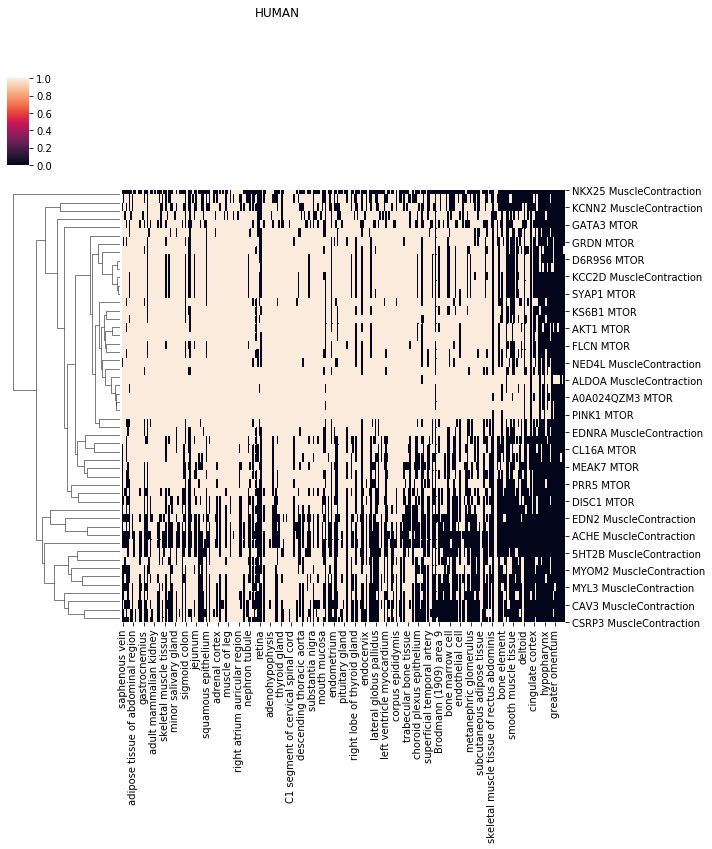

DROME


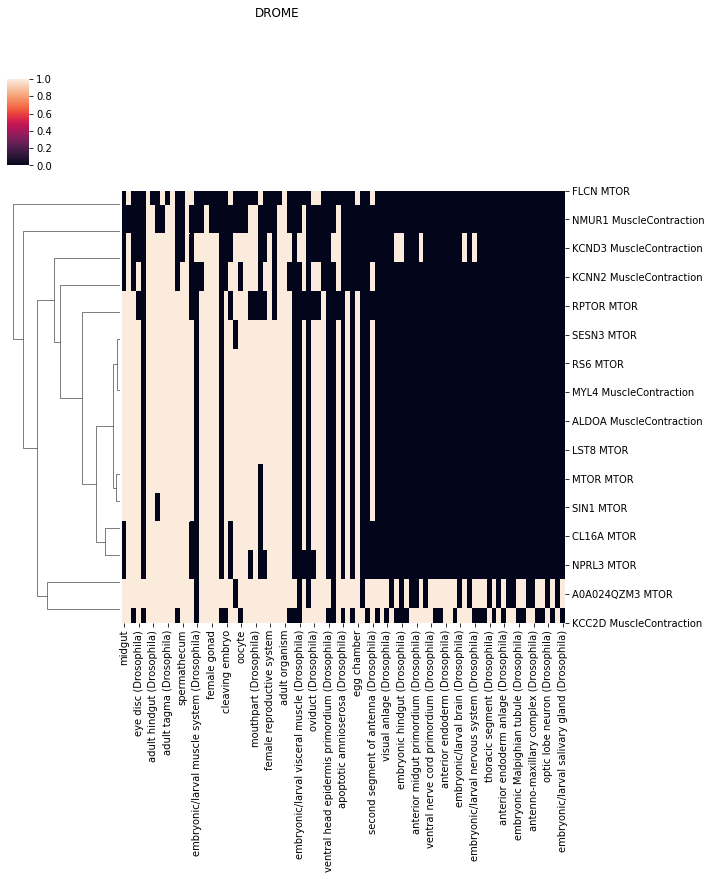

CAEEL


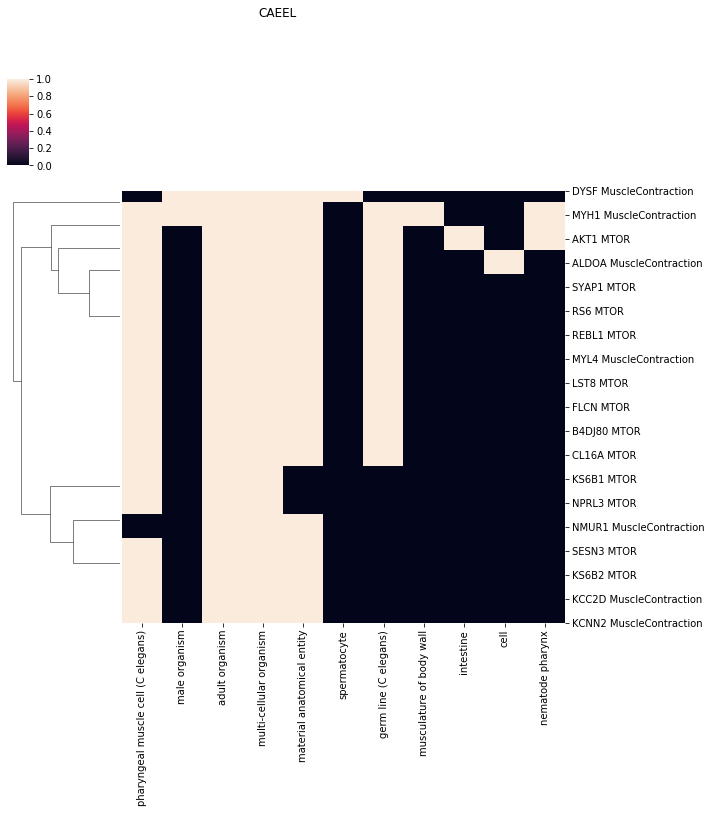

DANRE


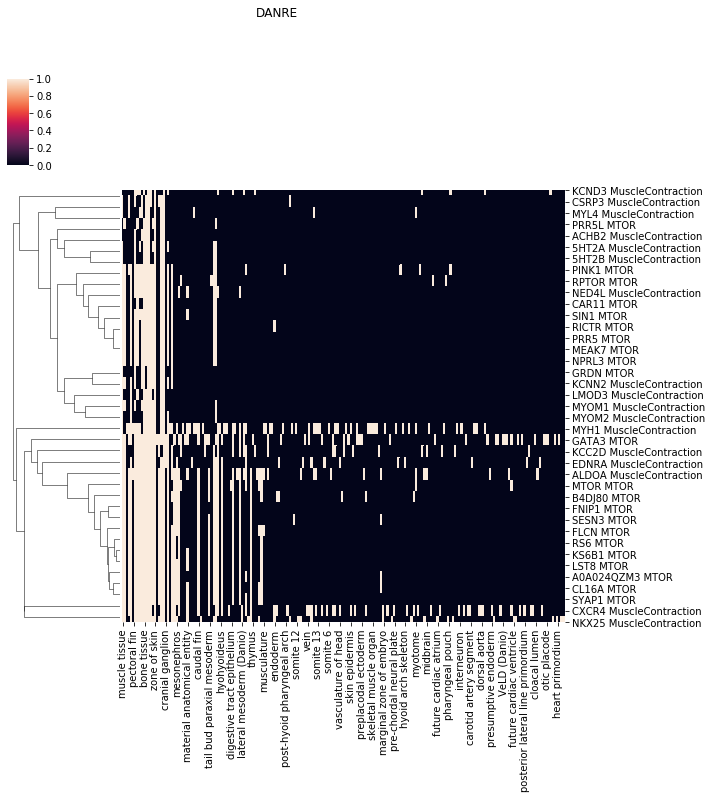

MOUSE


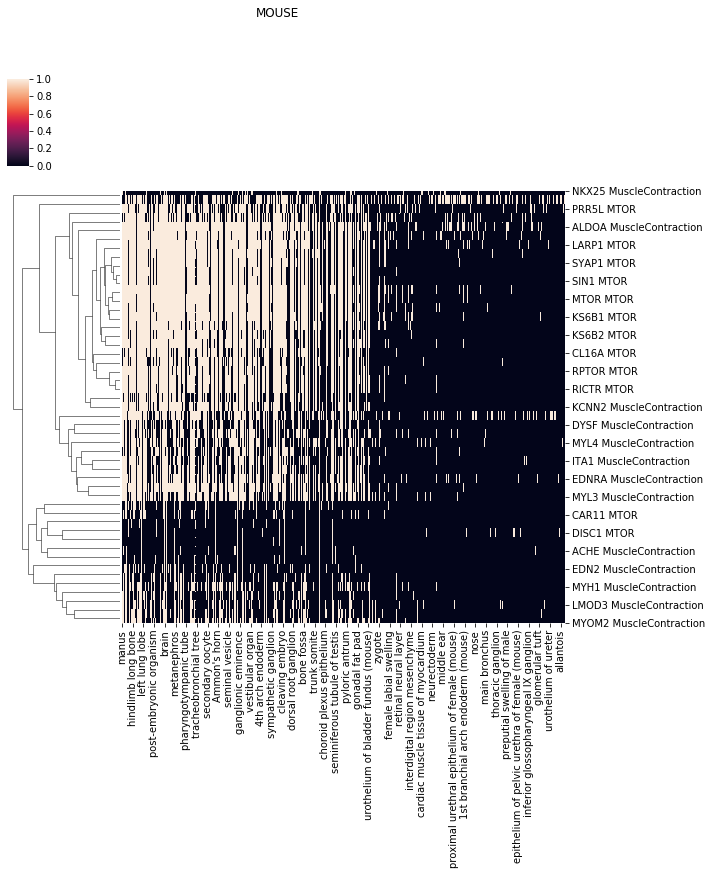

In [78]:
for spec in expressionDF.species.unique():
    print(spec)
    sub = expressionDF[expressionDF.species == spec]
    #we can create another dataframe which shows the genes expressed in each tissue
    #each row is a gene
    #each column is a tissue
    rows = list(sub.names.unique())
    columns = list(sub.index.unique())
    expr_mat = {r :{ c : 0 for c in columns  } for r in rows }
    #lets set all of the places where each gene is expressed to 1
    for i,r in sub.iterrows():
        expr_mat[r.names][i] = 1 
    #and transform everything into a dataframe
    expr_mat = pd.DataFrame.from_dict( expr_mat, orient='index')
    #to use seaborn again to generate a clustered heatmap figure
    g = sns.clustermap(expr_mat , metric= metrics[2] , method=methods[1] , col_cluster=False, row_cluster= True )
    g.fig.suptitle(spec)
    plt.show()
    

In [ ]:
#we can also lump everything together to see if the pattern holds true globally
